In [257]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sympy as sp
from IPython.display import clear_output
input_dim = 3

seed = 1234
is_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)


operators_uni = [
    "sin", "cos", "abs", "sqrt", "ln", "exp", "", "square"
]
operators_uni = [
    "sin", "cos", "sqrt", "", "square", "zeroise"
]
operators_bin = ["/", "+", "-", "*"]

#variables = ["const"] + [f"x{i}" for i in range(input_dim)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [258]:
def combine(x, bin=True):
    if bin:
        return len(operators_bin) * x ** 2 - 3 * x
    else:
        return len(operators_uni) * x 

In [259]:
def var_gen(n_var):
    return [f"x{i}" for i in range(n_var)]
def uni_gen(n_var):
    var = [i for i in range(n_var)]
    op = []
    for _i in operators_uni:
        for _j in var:
                op.append([_i, _j])
    return op
    
def bin_gen(n_var):
    variables = [i for i in range(n_var)]
    op = []
    for i_ in operators_bin:
        for j_ in variables:
            for k_ in variables:
                if (i_ == "/") and (j_ == k_):
                    pass
                elif (i_ == "-") and (j_ == k_):
                    pass
                elif (i_ == "+") and (j_ == k_):
                    pass
                elif (i_ == "*") and (j_ == k_):
                    pass
                else:
                    op.append([j_, i_, k_])
    op += [[i] for i in variables]
    return op

def bin_(op, x):
    if len(op) == 3:
        a, op, b = op[0], op[1], op[2]
        if op == "/":
            return x[:, a] / (x[:, b] + 0.01)
        elif op == "+":
            return x[:, a] + x[:, b]
        elif op == "*":
            return x[:, a] * x[:, b]
        elif op == "-":
            return x[:, a] - x[:, b]
    else:
        return x[:, op[0]]
def uni_(op, x):
    op, a = op[0], op[1]
    if op == "cos":
        return torch.cos(x[:, a])
    elif op == "sin":
        return torch.sin(x[:, a])
    elif op == "abs":
        return torch.abs(x[:, a])
    elif op == "ln":
        return torch.log(torch.abs(x[:, a]))
    elif op == "sqrt":
        return torch.sqrt(torch.abs(x[:, a]))
    elif op == "exp":
        return torch.exp(x[:, a])
    elif op == "square":
        return torch.square(x[:, a])
    elif op == "":
        return x[:, a]
    elif op=="zeroise":
        return torch.zeros_like(x[:,a])

def select(x, proba, current_var,  bin=True):
    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba.size()[1]):
        out_ = torch.sum(proba[:, var_, :] * output_var, dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

def select_argmax(x, proba, current_var,  bin=True):
    proba_argmax = np.zeros_like(proba.cpu().detach().numpy())
    max_indices = np.argmax(proba.cpu().detach().numpy(), axis=2)
    # Setting the corresponding indices to 1
    proba_argmax[np.arange(proba.shape[0])[:, None, None],
               np.arange(proba.shape[1])[None, :, None],
               max_indices[:, :, None]] = 1

    proba_argmax = torch.Tensor(proba_argmax)
    #print("PROB SHAPE", proba.shape)
    #print("Arg SHAPE", proba_argmax.shape)

    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba_argmax.size()[1]):
        out_ = torch.sum(proba_argmax[:, var_, :].to(device) * output_var, dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

In [260]:
def form(idxs, var, bin=True):
    if bin:
        vars = bin_gen(var)
    else:
        vars = uni_gen(var)
    formula = [vars[l.detach().cpu()] for l in idxs]
    return formula

In [261]:
class Formuler(nn.Module):
    def __init__(self, model):
        super(Formuler, self).__init__()
        self.model = model
        self.encoders = nn.ModuleList()

        for i in range(len(model)-1):
                odd = i % 2 != 0
                in_dim = model[i]
                out_dim = combine(model[i], bin=odd) * model[i + 1]
                encoder = nn.Sequential(
                    nn.Linear(in_dim, out_dim * 2),
                    nn.ReLU(),
                    nn.Linear(out_dim * 2, out_dim),
                    nn.Softmax(dim=1)
                )
                self.encoders.append(encoder)


    def forward(self, x):
        formula = []
        for i, encoder in enumerate(self.encoders):
            proba = encoder(x)
            proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
            x = select(x, proba, self.model[i], bin=(i % 2 != 0))

            pr_ = torch.mean(proba, dim=0)
            idx = []
            for c in range(self.model[i + 1]):
                idx.append(torch.argmax(pr_[c]))
            f = form(idx, self.model[i], bin=(i % 2 != 0))
            formula.append(f)
        return x, formula

    def evaluate_expression(self, x):
        formula = []
        for i, encoder in enumerate(self.encoders):
            proba = encoder(x)
            proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
            x = select_argmax(x, proba, self.model[i], bin=(i % 2 != 0))
            pr_ = torch.mean(proba, dim=0)
            idx = []
            for c in range(self.model[i + 1]):
                idx.append(torch.argmax(pr_[c]))
            f = form(idx, self.model[i], bin=(i % 2 != 0))
            formula.append(f)
        return x, formula


In [262]:
def decode(formula, x):
    for i in range(len(formula)):
        out = torch.Tensor([]).to(device)
        for f in formula[i]:
            if (i % 2 == 0):
                out_ =  uni_(f, x).unsqueeze(1)
            else:
                out_ =  bin_(f, x).unsqueeze(1)
            out = torch.cat((out, out_), 1)
        x = out
    return x

In [263]:
model = [3, 3, 2, 2, 1]
# Generate random data
x = np.random.rand(10000, model[0])

size_normal = 10000
size_uniform = 10000
size_exponential = 10000

data_normal = np.random.normal(0, 1, size_normal)
data_uniform = np.random.uniform(0, 1, size_uniform)
data_exponential = np.random.exponential(1, size_exponential)

x = np.array([data_normal, data_uniform, data_exponential]).T

y = x[:, 0] ** 2 + x[:, 1] + x[:, 2]
# Convert to PyTorch tensors
labels = torch.tensor(y, dtype=torch.float32)
features = torch.tensor(x, dtype=torch.float32)

# Create a TensorDataset
my_dataset = TensorDataset(features, labels)

# Create a DataLoader
batch_size = 16
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)
# Instantiate Formuler and set up optimizer
formuler = Formuler(model).to(device)
optimizer = optim.Adam(formuler.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
criterion = torch.nn.MSELoss()
# Example usage in a training loop
results = []
num_epochs = 100
formulas = set()
for epoch in range(num_epochs):
    losses = []
    formula_losses = []
    for batch_features, batch_labels in my_dataloader:
        # Your training code here
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        output, formula = formuler(batch_features)
        formula_out = decode(formula, batch_features)
        loss_formula = criterion(formula_out.squeeze(1).requires_grad_(), batch_labels)
        formula = " , ".join([' '.join(str(k) for k in j) for i in formula for j in i])
        loss = criterion(output.squeeze(1).requires_grad_(), batch_labels)
        losses.append(loss)
        loss = loss + 0.01 * loss_formula
        #print(loss, not torch.isnan(loss))
        formulas.add(formula)
        loss.backward()
        optimizer.step()
        scheduler.step()
        formula_losses.append(loss_formula)
    print(f"EPOCH[{epoch}] loss : {sum(losses) / len(losses):.4f}, formula_loss : {sum(formula_losses) / len(formula_losses):.4f}, n_explored formulas : {len(formulas)}, formula : ({formula})")

EPOCH[0] loss : 393.3451, formula_loss : 339.6145, n_explored formulas : 34, formula : ( 2 , cos 0 ,  2 , 0 / 1 , 2 / 1 , sin 1 , sqrt 1 , 0 / 1)
EPOCH[1] loss : 3.0624, formula_loss : 9.6148, n_explored formulas : 37, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 1 , sin 0 , sqrt 1 , 0 / 1)
EPOCH[2] loss : 2.6286, formula_loss : 9.3678, n_explored formulas : 38, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 1 , sin 0 , sqrt 1 , 0 / 1)
EPOCH[3] loss : 2.3229, formula_loss : 1415.3424, n_explored formulas : 40, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 1 , sin 0 , sqrt 1 , 1 * 0)
EPOCH[4] loss : 2.0527, formula_loss : 44.4698, n_explored formulas : 43, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 1 , sin 0 , sqrt 1 , 1 * 0)
EPOCH[5] loss : 2.0561, formula_loss : 60.0798, n_explored formulas : 43, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 1 , sin 0 , sqrt 1 , 1 * 0)
EPOCH[6] loss : 1.8002, formula_loss : 60.0563, n_explored formulas : 44, formula : ( 2 , zeroise 0 ,  2 , 0 / 1 , 2 / 

KeyboardInterrupt: 

torch.Size([10000, 3])


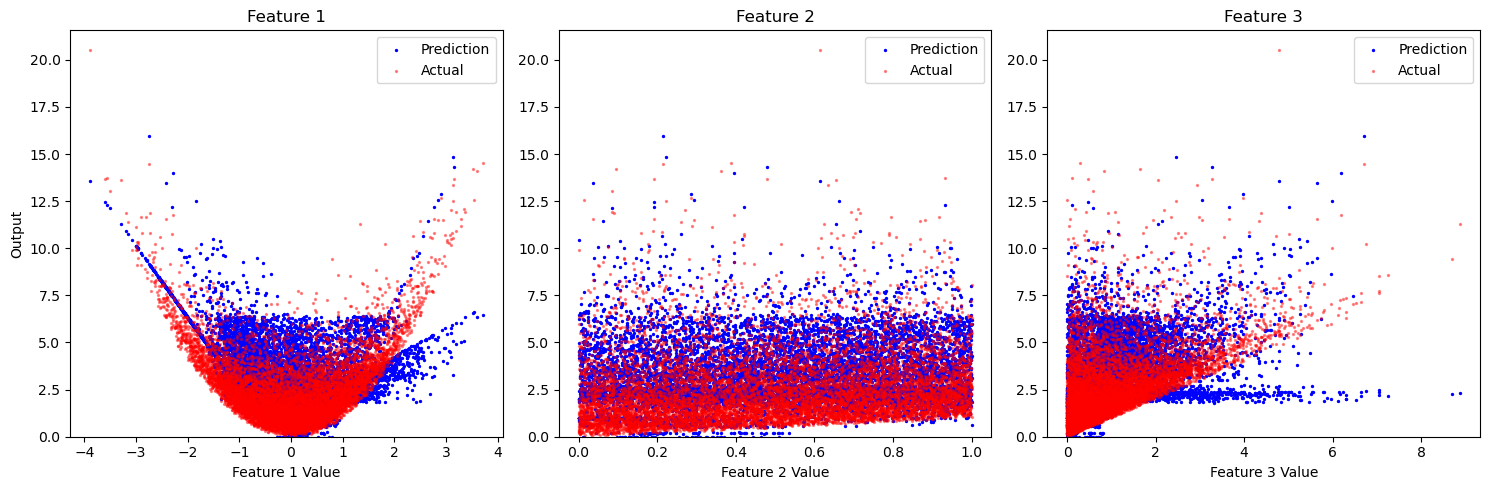

In [268]:
import matplotlib.pyplot as plt

x, formula = formuler.evaluate_expression(features.to(device))
x = x.detach().cpu()
print(features.shape)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()
